In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

In [3]:
# df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
#data = df.drop(labels=['date','rv1','rv2'], axis=1)
# data
filename = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/HomeC.csv'
data = pd.read_csv(filename)
data.pop('time')
data.pop('House overall [kW]')
data.pop('cloudCover')
data.pop('summary')
data.pop('icon')
data.dropna()


/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],...,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
0,0.932833,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
1,0.934333,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
2,0.931817,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
3,1.022050,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
4,1.139400,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,...,36.14,0.62,10.00,29.26,1016.91,9.18,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503905,1.601233,0.003183,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503906,1.599333,0.003233,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503907,1.924267,0.003217,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51
503908,1.978200,0.003217,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,...,35.12,0.86,8.74,29.45,1011.49,6.72,186.0,0.0101,31.27,0.51


In [10]:
# No treinamento eu recebo os dados de treino completo, a variável alvo e a epocas
# Faço o treinamento do AE e a redução dos dados de treino.
# Crio o modelo WMVFTS e treino ele com os dados "encodificados (com dimensão reduzida)" 
def train_reducted(train, Y, epochs):
    
    input_layer = Input(shape=(26, ))
    encoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder_layer_2 = Dense(2, activation="tanh")(encoder_layer_1)

    decoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder_layer_2)
    decoder_layer_2 = Dense(26, activation="tanh")(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)
    autoencoder.compile(optimizer = 'adam', loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs)

    encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder_model.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2']
    encoded_train = encoded_train.join(Y)
    
    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("use [kW]", data_label="use [kW]", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
    fts_model.fit(encoded_train)

    return fts_model, encoder_model, encoded_train


In [11]:
# No treino eu recebo o modelo WMVFTS treinado, o AE treinado, os dados te teste e a variável alvo
# Eu uso o AE treinado para reduzir a dimensão dos dados do treino
# Eu uso o WMVFTS treinado para fazer a previsão passando os dados de teste reduzidos
def forecast_reducted(fts_model, encoder_model,test, Y):
        
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(test)
    
    encoded_test = pd.DataFrame(encoder_model.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2']
    encoded_test = encoded_test.join(Y)
    
    forecasts = fts_model.predict(encoded_test)

    return forecasts, encoded_test

In [12]:
# exog = data.loc[:,'lights':'Tdewpoint']
# len(exog.columns)

--------------------
training window 0
Epoch 1/50
394/394 [==============================] - 1s 733us/step - loss: 0.0873
Epoch 2/50
394/394 [==============================] - 0s 803us/step - loss: 0.0341
Epoch 3/50
394/394 [==============================] - 0s 751us/step - loss: 0.0303
Epoch 4/50
394/394 [==============================] - 0s 564us/step - loss: 0.0271
Epoch 5/50
394/394 [==============================] - 0s 553us/step - loss: 0.0260
Epoch 6/50
394/394 [==============================] - 0s 616us/step - loss: 0.0258
Epoch 7/50
394/394 [==============================] - 0s 747us/step - loss: 0.0254
Epoch 8/50
394/394 [==============================] - 0s 591us/step - loss: 0.0254
Epoch 9/50
394/394 [==============================] - 0s 571us/step - loss: 0.0249
Epoch 10/50
394/394 [==============================] - 0s 567us/step - loss: 0.0245
Epoch 11/50
394/394 [==============================] - 0s 585us/step - loss: 0.0241
Epoch 12/50
394/394 [=========================

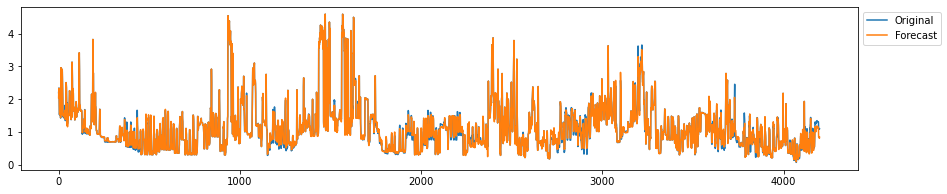

--------------------
training window 16797
Epoch 1/50
394/394 [==============================] - 0s 532us/step - loss: 0.0725
Epoch 2/50
394/394 [==============================] - 0s 501us/step - loss: 0.0260
Epoch 3/50
394/394 [==============================] - 0s 525us/step - loss: 0.0241
Epoch 4/50
394/394 [==============================] - 0s 479us/step - loss: 0.0230
Epoch 5/50
394/394 [==============================] - 0s 504us/step - loss: 0.0224
Epoch 6/50
394/394 [==============================] - 0s 496us/step - loss: 0.0220
Epoch 7/50
394/394 [==============================] - 0s 482us/step - loss: 0.0219
Epoch 8/50
394/394 [==============================] - 0s 479us/step - loss: 0.0211
Epoch 9/50
394/394 [==============================] - 0s 491us/step - loss: 0.0205
Epoch 10/50
394/394 [==============================] - 0s 579us/step - loss: 0.0204
Epoch 11/50
394/394 [==============================] - 0s 639us/step - loss: 0.0200
Epoch 12/50
394/394 [=====================

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 23:46:46] getting statistics


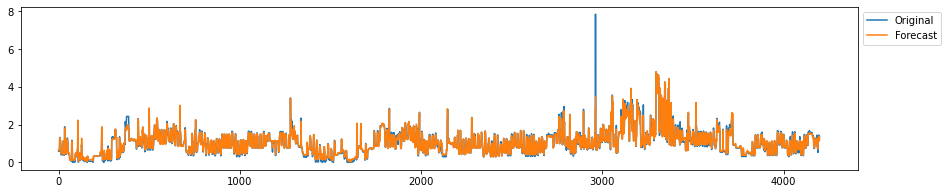

--------------------
training window 33594
Epoch 1/50
394/394 [==============================] - 1s 621us/step - loss: 0.0676
Epoch 2/50
394/394 [==============================] - 0s 697us/step - loss: 0.0305
Epoch 3/50
394/394 [==============================] - 0s 693us/step - loss: 0.0294
Epoch 4/50
394/394 [==============================] - 0s 661us/step - loss: 0.0281
Epoch 5/50
394/394 [==============================] - 0s 653us/step - loss: 0.0264
Epoch 6/50
394/394 [==============================] - 0s 656us/step - loss: 0.0254
Epoch 7/50
394/394 [==============================] - 0s 642us/step - loss: 0.0252
Epoch 8/50
394/394 [==============================] - 0s 634us/step - loss: 0.0248
Epoch 9/50
394/394 [==============================] - 0s 648us/step - loss: 0.0245
Epoch 10/50
394/394 [==============================] - 0s 651us/step - loss: 0.0246
Epoch 11/50
394/394 [==============================] - 0s 645us/step - loss: 0.0245
Epoch 12/50
394/394 [=====================

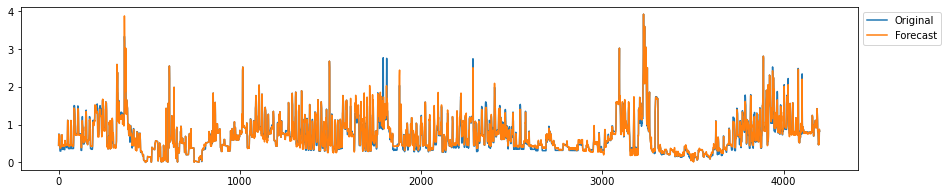

--------------------
training window 50391
Epoch 1/50
394/394 [==============================] - 1s 581us/step - loss: 0.0984
Epoch 2/50
394/394 [==============================] - 0s 669us/step - loss: 0.0343
Epoch 3/50
394/394 [==============================] - 0s 738us/step - loss: 0.0283
Epoch 4/50
394/394 [==============================] - 0s 612us/step - loss: 0.0267
Epoch 5/50
394/394 [==============================] - 0s 627us/step - loss: 0.0255
Epoch 6/50
394/394 [==============================] - 0s 719us/step - loss: 0.0237
Epoch 7/50
394/394 [==============================] - 0s 676us/step - loss: 0.0228
Epoch 8/50
394/394 [==============================] - 0s 679us/step - loss: 0.0226
Epoch 9/50
394/394 [==============================] - 0s 671us/step - loss: 0.0226
Epoch 10/50
394/394 [==============================] - 0s 920us/step - loss: 0.0221
Epoch 11/50
394/394 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 12/50
394/394 [=======================

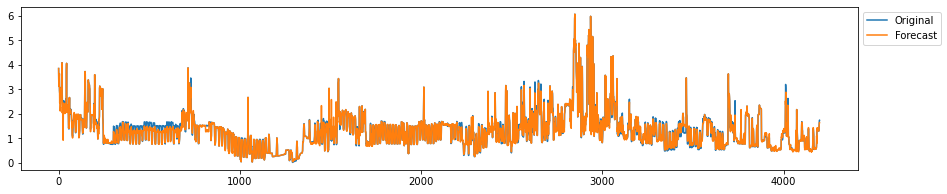

--------------------
training window 67188
Epoch 1/50
394/394 [==============================] - 1s 799us/step - loss: 0.0922
Epoch 2/50
394/394 [==============================] - 0s 785us/step - loss: 0.0313
Epoch 3/50
394/394 [==============================] - 0s 780us/step - loss: 0.0287
Epoch 4/50
394/394 [==============================] - 0s 788us/step - loss: 0.0269
Epoch 5/50
394/394 [==============================] - 0s 808us/step - loss: 0.0265
Epoch 6/50
394/394 [==============================] - 0s 805us/step - loss: 0.0260
Epoch 7/50
394/394 [==============================] - 0s 809us/step - loss: 0.0256
Epoch 8/50
394/394 [==============================] - 0s 814us/step - loss: 0.0242
Epoch 9/50
394/394 [==============================] - 0s 825us/step - loss: 0.0241
Epoch 10/50
394/394 [==============================] - 0s 840us/step - loss: 0.0237
Epoch 11/50
394/394 [==============================] - 0s 905us/step - loss: 0.0236
Epoch 12/50
394/394 [=====================

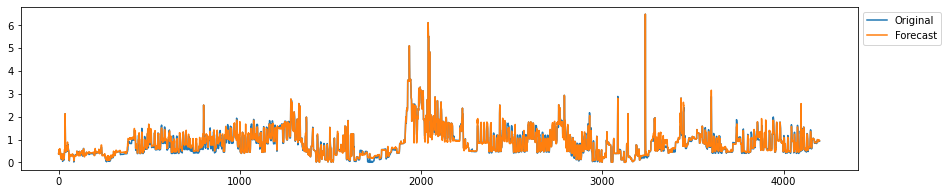

--------------------
training window 83985
Epoch 1/50
394/394 [==============================] - 1s 977us/step - loss: 0.0685
Epoch 2/50
394/394 [==============================] - 0s 780us/step - loss: 0.0315
Epoch 3/50
394/394 [==============================] - 0s 687us/step - loss: 0.0283
Epoch 4/50
394/394 [==============================] - 0s 704us/step - loss: 0.0275
Epoch 5/50
394/394 [==============================] - 0s 841us/step - loss: 0.0272
Epoch 6/50
394/394 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 7/50
394/394 [==============================] - 0s 809us/step - loss: 0.0261
Epoch 8/50
394/394 [==============================] - 0s 879us/step - loss: 0.0254
Epoch 9/50
394/394 [==============================] - 0s 687us/step - loss: 0.0244
Epoch 10/50
394/394 [==============================] - 0s 637us/step - loss: 0.0232
Epoch 11/50
394/394 [==============================] - 0s 722us/step - loss: 0.0220
Epoch 12/50
394/394 [=======================

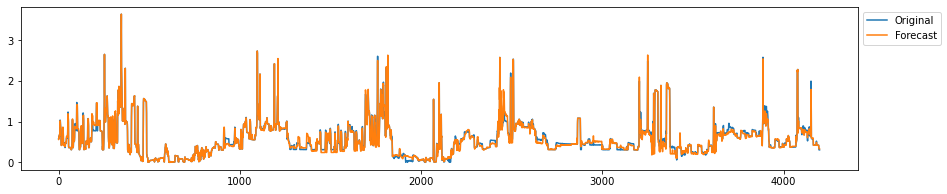

--------------------
training window 100782
Epoch 1/50
394/394 [==============================] - 1s 705us/step - loss: 0.0847
Epoch 2/50
394/394 [==============================] - 0s 668us/step - loss: 0.0355
Epoch 3/50
394/394 [==============================] - 0s 585us/step - loss: 0.0314
Epoch 4/50
394/394 [==============================] - 0s 656us/step - loss: 0.0293
Epoch 5/50
394/394 [==============================] - 0s 680us/step - loss: 0.0281
Epoch 6/50
394/394 [==============================] - 0s 685us/step - loss: 0.0275
Epoch 7/50
394/394 [==============================] - 0s 676us/step - loss: 0.0267
Epoch 8/50
394/394 [==============================] - 0s 684us/step - loss: 0.0257
Epoch 9/50
394/394 [==============================] - 0s 656us/step - loss: 0.0256
Epoch 10/50
394/394 [==============================] - 0s 650us/step - loss: 0.0254
Epoch 11/50
394/394 [==============================] - 0s 650us/step - loss: 0.0251
Epoch 12/50
394/394 [====================

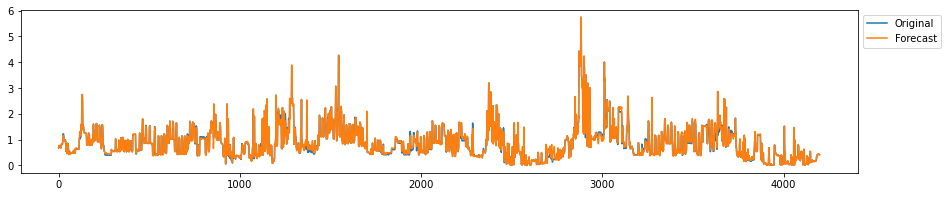

--------------------
training window 117579
Epoch 1/50
394/394 [==============================] - 1s 593us/step - loss: 0.0794
Epoch 2/50
394/394 [==============================] - 0s 630us/step - loss: 0.0304
Epoch 3/50
394/394 [==============================] - 0s 644us/step - loss: 0.0256
Epoch 4/50
394/394 [==============================] - 0s 641us/step - loss: 0.0238
Epoch 5/50
394/394 [==============================] - 0s 663us/step - loss: 0.0228
Epoch 6/50
394/394 [==============================] - 0s 666us/step - loss: 0.0218
Epoch 7/50
394/394 [==============================] - 0s 663us/step - loss: 0.0211
Epoch 8/50
394/394 [==============================] - 0s 662us/step - loss: 0.0207
Epoch 9/50
394/394 [==============================] - 0s 671us/step - loss: 0.0207
Epoch 10/50
394/394 [==============================] - 0s 656us/step - loss: 0.0198
Epoch 11/50
394/394 [==============================] - 0s 654us/step - loss: 0.0197
Epoch 12/50
394/394 [====================

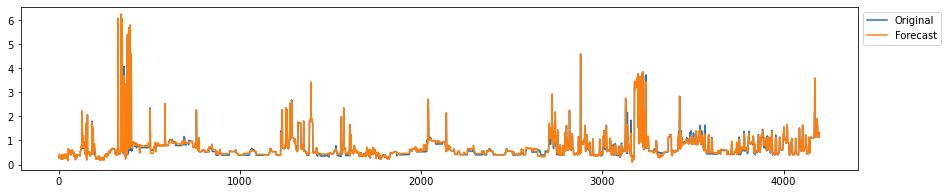

--------------------
training window 134376
Epoch 1/50
394/394 [==============================] - 1s 609us/step - loss: 0.0798
Epoch 2/50
394/394 [==============================] - 0s 654us/step - loss: 0.0364
Epoch 3/50
394/394 [==============================] - 0s 665us/step - loss: 0.0314
Epoch 4/50
394/394 [==============================] - 0s 668us/step - loss: 0.0291
Epoch 5/50
394/394 [==============================] - 0s 671us/step - loss: 0.0273
Epoch 6/50
394/394 [==============================] - 0s 671us/step - loss: 0.0261
Epoch 7/50
394/394 [==============================] - 0s 664us/step - loss: 0.0254
Epoch 8/50
394/394 [==============================] - 0s 707us/step - loss: 0.0254
Epoch 9/50
394/394 [==============================] - 0s 814us/step - loss: 0.0252
Epoch 10/50
394/394 [==============================] - 0s 732us/step - loss: 0.0250
Epoch 11/50
394/394 [==============================] - 0s 688us/step - loss: 0.0249
Epoch 12/50
394/394 [====================

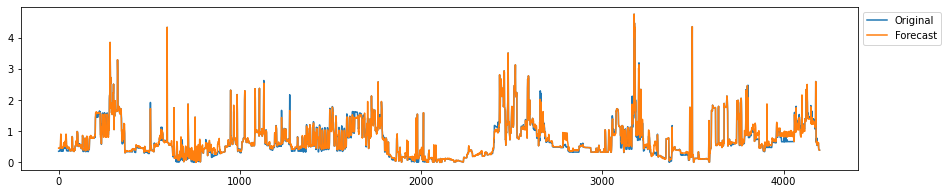

--------------------
training window 151173
Epoch 1/50
394/394 [==============================] - 1s 599us/step - loss: 0.0844
Epoch 2/50
394/394 [==============================] - 0s 618us/step - loss: 0.0303
Epoch 3/50
394/394 [==============================] - 0s 636us/step - loss: 0.0257
Epoch 4/50
394/394 [==============================] - 0s 666us/step - loss: 0.0237
Epoch 5/50
394/394 [==============================] - 0s 636us/step - loss: 0.0231
Epoch 6/50
394/394 [==============================] - 0s 634us/step - loss: 0.0226
Epoch 7/50
394/394 [==============================] - 0s 648us/step - loss: 0.0225
Epoch 8/50
394/394 [==============================] - 0s 674us/step - loss: 0.0225
Epoch 9/50
394/394 [==============================] - 0s 644us/step - loss: 0.0223
Epoch 10/50
394/394 [==============================] - 0s 652us/step - loss: 0.0221
Epoch 11/50
394/394 [==============================] - 0s 670us/step - loss: 0.0222
Epoch 12/50
394/394 [====================

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 23:51:19] getting statistics


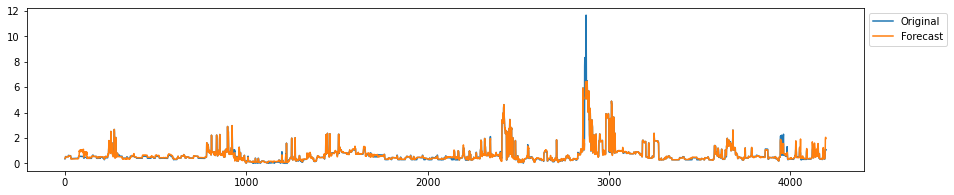

--------------------
training window 167970
Epoch 1/50
394/394 [==============================] - 1s 606us/step - loss: 0.0665
Epoch 2/50
394/394 [==============================] - 0s 635us/step - loss: 0.0331
Epoch 3/50
394/394 [==============================] - 0s 692us/step - loss: 0.0281
Epoch 4/50
394/394 [==============================] - 0s 662us/step - loss: 0.0260
Epoch 5/50
394/394 [==============================] - 0s 757us/step - loss: 0.0248
Epoch 6/50
394/394 [==============================] - 0s 759us/step - loss: 0.0242
Epoch 7/50
394/394 [==============================] - 0s 629us/step - loss: 0.0242
Epoch 8/50
394/394 [==============================] - 0s 638us/step - loss: 0.0235
Epoch 9/50
394/394 [==============================] - 0s 677us/step - loss: 0.0235
Epoch 10/50
394/394 [==============================] - 0s 633us/step - loss: 0.0231
Epoch 11/50
394/394 [==============================] - 0s 614us/step - loss: 0.0231
Epoch 12/50
394/394 [====================

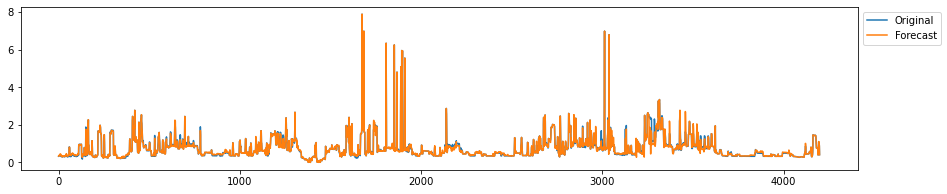

--------------------
training window 184767
Epoch 1/50
394/394 [==============================] - 1s 742us/step - loss: 0.0653
Epoch 2/50
394/394 [==============================] - 0s 938us/step - loss: 0.0263
Epoch 3/50
394/394 [==============================] - 0s 785us/step - loss: 0.0232
Epoch 4/50
394/394 [==============================] - 0s 938us/step - loss: 0.0214
Epoch 5/50
394/394 [==============================] - 0s 683us/step - loss: 0.0208
Epoch 6/50
394/394 [==============================] - 0s 731us/step - loss: 0.0198
Epoch 7/50
394/394 [==============================] - 0s 757us/step - loss: 0.0194
Epoch 8/50
394/394 [==============================] - 0s 1ms/step - loss: 0.0190
Epoch 9/50
394/394 [==============================] - 0s 773us/step - loss: 0.0191
Epoch 10/50
394/394 [==============================] - 0s 789us/step - loss: 0.0189
Epoch 11/50
394/394 [==============================] - 0s 722us/step - loss: 0.0186
Epoch 12/50
394/394 [======================

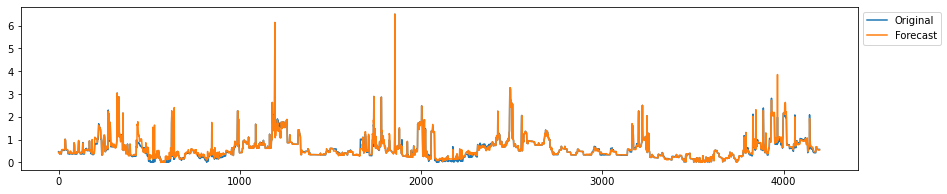

--------------------
training window 201564
Epoch 1/50
394/394 [==============================] - 1s 619us/step - loss: 0.0956
Epoch 2/50
394/394 [==============================] - 0s 761us/step - loss: 0.0295
Epoch 3/50
394/394 [==============================] - 0s 805us/step - loss: 0.0250
Epoch 4/50
394/394 [==============================] - 0s 760us/step - loss: 0.0225
Epoch 5/50
394/394 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 6/50
394/394 [==============================] - 0s 913us/step - loss: 0.0199
Epoch 7/50
394/394 [==============================] - 0s 839us/step - loss: 0.0196
Epoch 8/50
394/394 [==============================] - 0s 648us/step - loss: 0.0194
Epoch 9/50
394/394 [==============================] - 0s 960us/step - loss: 0.0190
Epoch 10/50
394/394 [==============================] - 0s 912us/step - loss: 0.0190
Epoch 11/50
394/394 [==============================] - 0s 773us/step - loss: 0.0187
Epoch 12/50
394/394 [======================

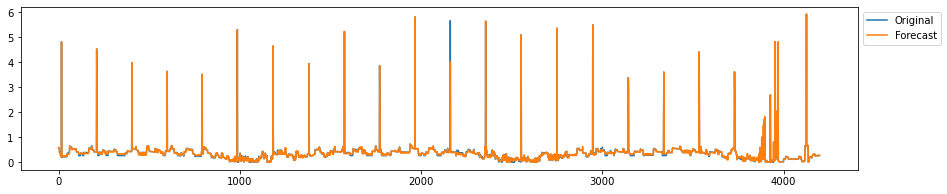

--------------------
training window 218361
Epoch 1/50
394/394 [==============================] - 1s 610us/step - loss: 0.0743
Epoch 2/50
394/394 [==============================] - 0s 629us/step - loss: 0.0236
Epoch 3/50
394/394 [==============================] - 0s 641us/step - loss: 0.0217
Epoch 4/50
394/394 [==============================] - 0s 667us/step - loss: 0.0194
Epoch 5/50
394/394 [==============================] - 0s 759us/step - loss: 0.0169
Epoch 6/50
394/394 [==============================] - 0s 714us/step - loss: 0.0166
Epoch 7/50
394/394 [==============================] - 0s 647us/step - loss: 0.0164
Epoch 8/50
394/394 [==============================] - 0s 696us/step - loss: 0.0164
Epoch 9/50
394/394 [==============================] - 0s 682us/step - loss: 0.0162
Epoch 10/50
394/394 [==============================] - 0s 816us/step - loss: 0.0163
Epoch 11/50
394/394 [==============================] - 0s 683us/step - loss: 0.0160
Epoch 12/50
394/394 [====================

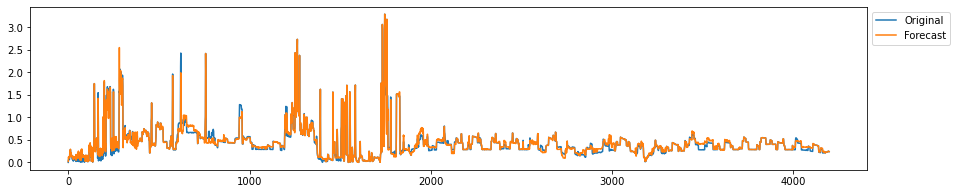

--------------------
training window 235158
Epoch 1/50
394/394 [==============================] - 1s 589us/step - loss: 0.0827
Epoch 2/50
394/394 [==============================] - 0s 657us/step - loss: 0.0270
Epoch 3/50
394/394 [==============================] - 0s 659us/step - loss: 0.0246
Epoch 4/50
394/394 [==============================] - 0s 684us/step - loss: 0.0236
Epoch 5/50
394/394 [==============================] - 0s 708us/step - loss: 0.0229
Epoch 6/50
394/394 [==============================] - 0s 939us/step - loss: 0.0224
Epoch 7/50
394/394 [==============================] - 0s 785us/step - loss: 0.0220
Epoch 8/50
394/394 [==============================] - 0s 708us/step - loss: 0.0221
Epoch 9/50
394/394 [==============================] - 0s 728us/step - loss: 0.0220
Epoch 10/50
394/394 [==============================] - 0s 790us/step - loss: 0.0219
Epoch 11/50
394/394 [==============================] - 0s 865us/step - loss: 0.0220
Epoch 12/50
394/394 [====================

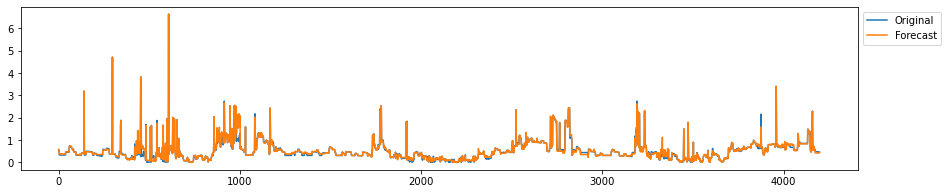

--------------------
training window 251955
Epoch 1/50
394/394 [==============================] - 1s 581us/step - loss: 0.0770
Epoch 2/50
394/394 [==============================] - 0s 625us/step - loss: 0.0302
Epoch 3/50
394/394 [==============================] - 0s 579us/step - loss: 0.0243
Epoch 4/50
394/394 [==============================] - 0s 591us/step - loss: 0.0216
Epoch 5/50
394/394 [==============================] - 0s 968us/step - loss: 0.0188
Epoch 6/50
394/394 [==============================] - 0s 645us/step - loss: 0.0178
Epoch 7/50
394/394 [==============================] - 0s 645us/step - loss: 0.0175
Epoch 8/50
394/394 [==============================] - 0s 649us/step - loss: 0.0169
Epoch 9/50
394/394 [==============================] - 0s 643us/step - loss: 0.0167
Epoch 10/50
394/394 [==============================] - 0s 581us/step - loss: 0.0167
Epoch 11/50
394/394 [==============================] - 0s 606us/step - loss: 0.0167
Epoch 12/50
394/394 [====================

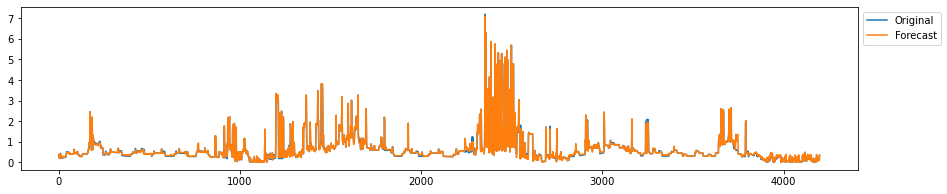

--------------------
training window 268752
Epoch 1/50
394/394 [==============================] - 0s 482us/step - loss: 0.0918
Epoch 2/50
394/394 [==============================] - 0s 467us/step - loss: 0.0296
Epoch 3/50
394/394 [==============================] - 0s 461us/step - loss: 0.0244
Epoch 4/50
394/394 [==============================] - 0s 461us/step - loss: 0.0223
Epoch 5/50
394/394 [==============================] - 0s 472us/step - loss: 0.0214
Epoch 6/50
394/394 [==============================] - 0s 568us/step - loss: 0.0209
Epoch 7/50
394/394 [==============================] - 0s 574us/step - loss: 0.0206
Epoch 8/50
394/394 [==============================] - 0s 469us/step - loss: 0.0190
Epoch 9/50
394/394 [==============================] - 0s 477us/step - loss: 0.0176
Epoch 10/50
394/394 [==============================] - 0s 496us/step - loss: 0.0176
Epoch 11/50
394/394 [==============================] - 0s 507us/step - loss: 0.0174
Epoch 12/50
394/394 [====================

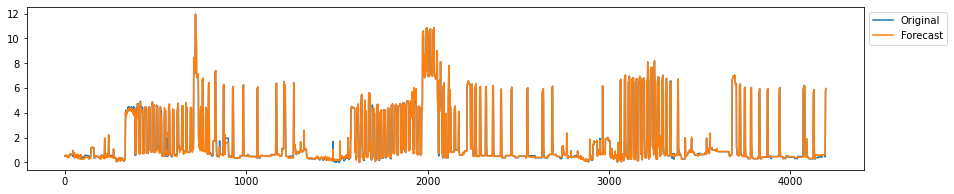

--------------------
training window 285549
Epoch 1/50
394/394 [==============================] - 0s 475us/step - loss: 0.0883
Epoch 2/50
394/394 [==============================] - 0s 464us/step - loss: 0.0314
Epoch 3/50
394/394 [==============================] - 0s 463us/step - loss: 0.0282
Epoch 4/50
394/394 [==============================] - 0s 469us/step - loss: 0.0264
Epoch 5/50
394/394 [==============================] - 0s 466us/step - loss: 0.0258
Epoch 6/50
394/394 [==============================] - 0s 471us/step - loss: 0.0253
Epoch 7/50
394/394 [==============================] - 0s 472us/step - loss: 0.0250
Epoch 8/50
394/394 [==============================] - 0s 472us/step - loss: 0.0250
Epoch 9/50
394/394 [==============================] - 0s 465us/step - loss: 0.0250
Epoch 10/50
394/394 [==============================] - 0s 535us/step - loss: 0.0247
Epoch 11/50
394/394 [==============================] - 0s 506us/step - loss: 0.0247
Epoch 12/50
394/394 [====================

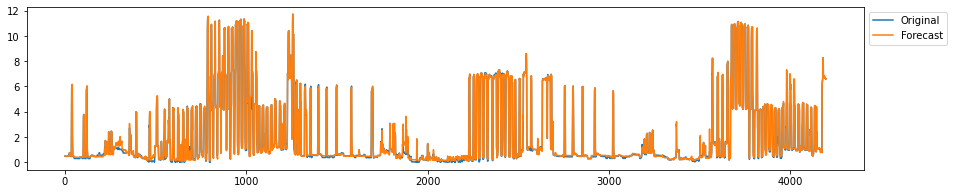

--------------------
training window 302346
Epoch 1/50
394/394 [==============================] - 0s 457us/step - loss: 0.0910
Epoch 2/50
394/394 [==============================] - 0s 452us/step - loss: 0.0281
Epoch 3/50
394/394 [==============================] - 0s 452us/step - loss: 0.0266
Epoch 4/50
394/394 [==============================] - 0s 463us/step - loss: 0.0247
Epoch 5/50
394/394 [==============================] - 0s 495us/step - loss: 0.0232
Epoch 6/50
394/394 [==============================] - 0s 511us/step - loss: 0.0213
Epoch 7/50
394/394 [==============================] - 0s 514us/step - loss: 0.0205
Epoch 8/50
394/394 [==============================] - 0s 514us/step - loss: 0.0203
Epoch 9/50
394/394 [==============================] - 0s 504us/step - loss: 0.0200
Epoch 10/50
394/394 [==============================] - 0s 510us/step - loss: 0.0199
Epoch 11/50
394/394 [==============================] - 0s 521us/step - loss: 0.0199
Epoch 12/50
394/394 [====================

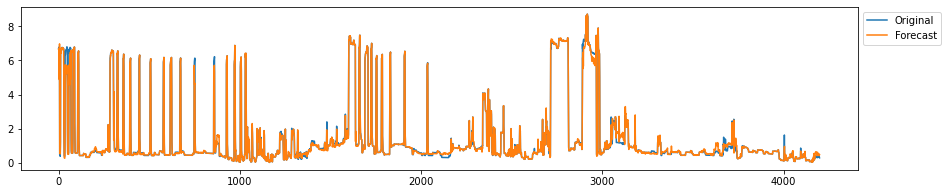

--------------------
training window 319143
Epoch 1/50
394/394 [==============================] - 1s 592us/step - loss: 0.0882
Epoch 2/50
394/394 [==============================] - 0s 630us/step - loss: 0.0337
Epoch 3/50
394/394 [==============================] - 0s 646us/step - loss: 0.0287
Epoch 4/50
394/394 [==============================] - 0s 630us/step - loss: 0.0268
Epoch 5/50
394/394 [==============================] - 0s 628us/step - loss: 0.0261
Epoch 6/50
394/394 [==============================] - 0s 639us/step - loss: 0.0255
Epoch 7/50
394/394 [==============================] - 0s 628us/step - loss: 0.0250
Epoch 8/50
394/394 [==============================] - 0s 628us/step - loss: 0.0249
Epoch 9/50
394/394 [==============================] - 0s 650us/step - loss: 0.0251
Epoch 10/50
394/394 [==============================] - 0s 659us/step - loss: 0.0248
Epoch 11/50
394/394 [==============================] - 0s 636us/step - loss: 0.0246
Epoch 12/50
394/394 [====================

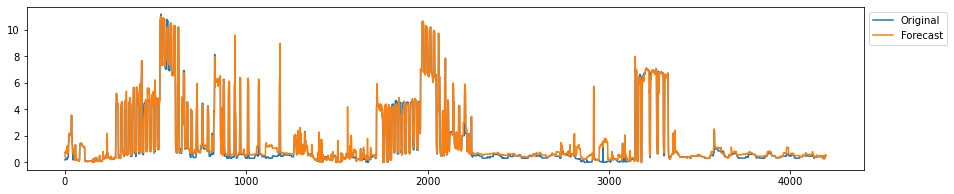

--------------------
training window 335940
Epoch 1/50
394/394 [==============================] - 1s 664us/step - loss: 0.0678
Epoch 2/50
394/394 [==============================] - 0s 625us/step - loss: 0.0252
Epoch 3/50
394/394 [==============================] - 0s 647us/step - loss: 0.0209
Epoch 4/50
394/394 [==============================] - 0s 636us/step - loss: 0.0188
Epoch 5/50
394/394 [==============================] - 0s 643us/step - loss: 0.0184
Epoch 6/50
394/394 [==============================] - 0s 689us/step - loss: 0.0181
Epoch 7/50
394/394 [==============================] - 0s 643us/step - loss: 0.0179
Epoch 8/50
394/394 [==============================] - 0s 698us/step - loss: 0.0176
Epoch 9/50
394/394 [==============================] - 0s 656us/step - loss: 0.0175
Epoch 10/50
394/394 [==============================] - 0s 601us/step - loss: 0.0173
Epoch 11/50
394/394 [==============================] - 0s 642us/step - loss: 0.0168
Epoch 12/50
394/394 [====================

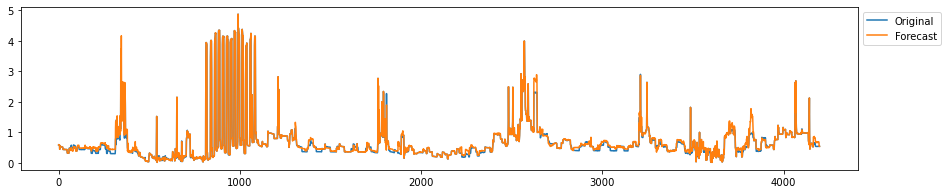

--------------------
training window 352737
Epoch 1/50
394/394 [==============================] - 1s 564us/step - loss: 0.0908
Epoch 2/50
394/394 [==============================] - 0s 584us/step - loss: 0.0322
Epoch 3/50
394/394 [==============================] - 0s 596us/step - loss: 0.0281
Epoch 4/50
394/394 [==============================] - 0s 629us/step - loss: 0.0257
Epoch 5/50
394/394 [==============================] - 0s 681us/step - loss: 0.0241
Epoch 6/50
394/394 [==============================] - 0s 615us/step - loss: 0.0236
Epoch 7/50
394/394 [==============================] - 0s 597us/step - loss: 0.0228
Epoch 8/50
394/394 [==============================] - 0s 590us/step - loss: 0.0228
Epoch 9/50
394/394 [==============================] - 0s 624us/step - loss: 0.0227
Epoch 10/50
394/394 [==============================] - 0s 618us/step - loss: 0.0226
Epoch 11/50
394/394 [==============================] - 0s 623us/step - loss: 0.0228
Epoch 12/50
394/394 [====================

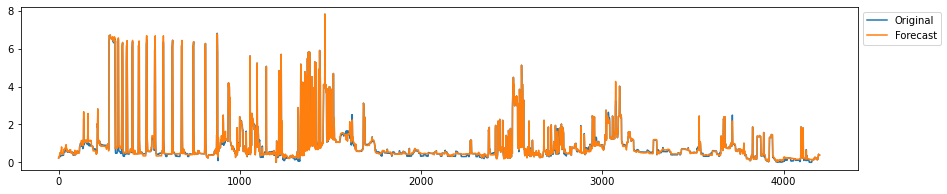

--------------------
training window 369534
Epoch 1/50
394/394 [==============================] - 1s 587us/step - loss: 0.0762
Epoch 2/50
394/394 [==============================] - 0s 586us/step - loss: 0.0348
Epoch 3/50
394/394 [==============================] - 0s 614us/step - loss: 0.0295
Epoch 4/50
394/394 [==============================] - 0s 591us/step - loss: 0.0274
Epoch 5/50
394/394 [==============================] - 0s 593us/step - loss: 0.0258
Epoch 6/50
394/394 [==============================] - 0s 626us/step - loss: 0.0241
Epoch 7/50
394/394 [==============================] - 0s 619us/step - loss: 0.0231
Epoch 8/50
394/394 [==============================] - 0s 618us/step - loss: 0.0225
Epoch 9/50
394/394 [==============================] - 0s 621us/step - loss: 0.0223
Epoch 10/50
394/394 [==============================] - 0s 650us/step - loss: 0.0222
Epoch 11/50
394/394 [==============================] - 0s 596us/step - loss: 0.0220
Epoch 12/50
394/394 [====================

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 23:58:08] getting statistics


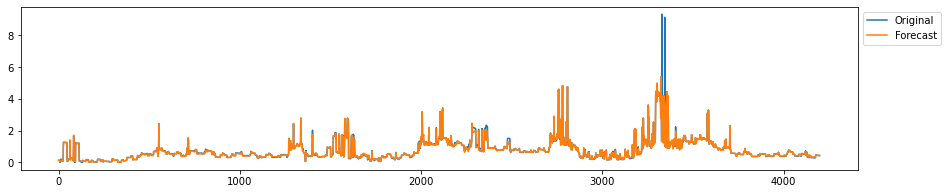

--------------------
training window 386331
Epoch 1/50
394/394 [==============================] - 1s 561us/step - loss: 0.0852
Epoch 2/50
394/394 [==============================] - 0s 579us/step - loss: 0.0337
Epoch 3/50
394/394 [==============================] - 0s 590us/step - loss: 0.0308
Epoch 4/50
394/394 [==============================] - 0s 611us/step - loss: 0.0278
Epoch 5/50
394/394 [==============================] - 0s 616us/step - loss: 0.0271
Epoch 6/50
394/394 [==============================] - 0s 624us/step - loss: 0.0267
Epoch 7/50
394/394 [==============================] - 0s 599us/step - loss: 0.0264
Epoch 8/50
394/394 [==============================] - 0s 577us/step - loss: 0.0264
Epoch 9/50
394/394 [==============================] - 0s 603us/step - loss: 0.0261
Epoch 10/50
394/394 [==============================] - 0s 571us/step - loss: 0.0249
Epoch 11/50
394/394 [==============================] - 0s 594us/step - loss: 0.0241
Epoch 12/50
394/394 [====================

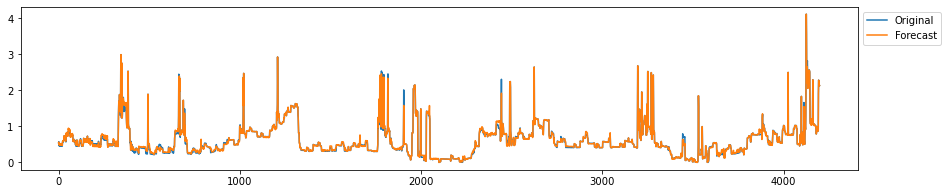

--------------------
training window 403128
Epoch 1/50
394/394 [==============================] - 1s 577us/step - loss: 0.0857
Epoch 2/50
394/394 [==============================] - 0s 581us/step - loss: 0.0333
Epoch 3/50
394/394 [==============================] - 0s 609us/step - loss: 0.0285
Epoch 4/50
394/394 [==============================] - 0s 604us/step - loss: 0.0256
Epoch 5/50
394/394 [==============================] - 0s 660us/step - loss: 0.0247
Epoch 6/50
394/394 [==============================] - 0s 654us/step - loss: 0.0244
Epoch 7/50
394/394 [==============================] - 0s 777us/step - loss: 0.0237
Epoch 8/50
394/394 [==============================] - 0s 699us/step - loss: 0.0235
Epoch 9/50
394/394 [==============================] - 0s 636us/step - loss: 0.0232
Epoch 10/50
394/394 [==============================] - 0s 611us/step - loss: 0.0230
Epoch 11/50
394/394 [==============================] - 0s 623us/step - loss: 0.0231
Epoch 12/50
394/394 [====================

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 23:59:11] getting statistics


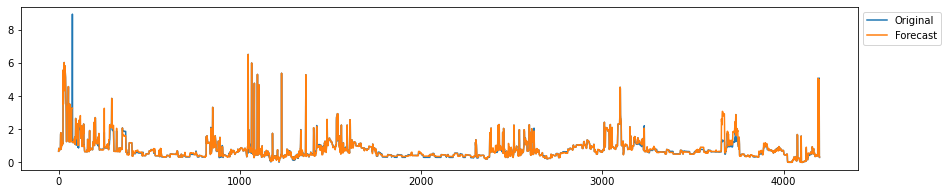

--------------------
training window 419925
Epoch 1/50
394/394 [==============================] - 1s 622us/step - loss: 0.0716
Epoch 2/50
394/394 [==============================] - 0s 594us/step - loss: 0.0326
Epoch 3/50
394/394 [==============================] - 0s 611us/step - loss: 0.0286
Epoch 4/50
394/394 [==============================] - 0s 605us/step - loss: 0.0269
Epoch 5/50
394/394 [==============================] - 0s 618us/step - loss: 0.0258
Epoch 6/50
394/394 [==============================] - 0s 655us/step - loss: 0.0249
Epoch 7/50
394/394 [==============================] - 0s 745us/step - loss: 0.0245
Epoch 8/50
394/394 [==============================] - 0s 751us/step - loss: 0.0239
Epoch 9/50
394/394 [==============================] - 0s 609us/step - loss: 0.0236
Epoch 10/50
394/394 [==============================] - 0s 605us/step - loss: 0.0228
Epoch 11/50
394/394 [==============================] - 0s 678us/step - loss: 0.0224
Epoch 12/50
394/394 [====================

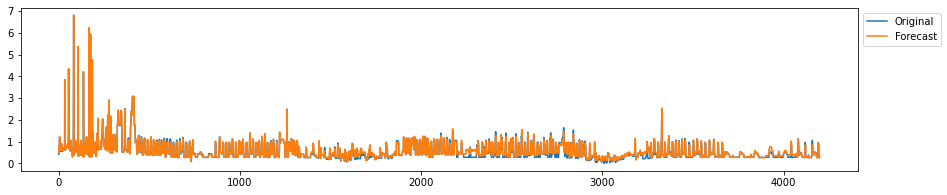

--------------------
training window 436722
Epoch 1/50
394/394 [==============================] - 1s 569us/step - loss: 0.0789
Epoch 2/50
394/394 [==============================] - 0s 705us/step - loss: 0.0351
Epoch 3/50
394/394 [==============================] - 0s 747us/step - loss: 0.0313
Epoch 4/50
394/394 [==============================] - 0s 704us/step - loss: 0.0287
Epoch 5/50
394/394 [==============================] - 0s 789us/step - loss: 0.0272
Epoch 6/50
394/394 [==============================] - 0s 719us/step - loss: 0.0253
Epoch 7/50
394/394 [==============================] - 0s 662us/step - loss: 0.0240
Epoch 8/50
394/394 [==============================] - 0s 764us/step - loss: 0.0235
Epoch 9/50
394/394 [==============================] - 0s 816us/step - loss: 0.0234
Epoch 10/50
394/394 [==============================] - 0s 680us/step - loss: 0.0230
Epoch 11/50
394/394 [==============================] - 0s 669us/step - loss: 0.0232
Epoch 12/50
394/394 [====================

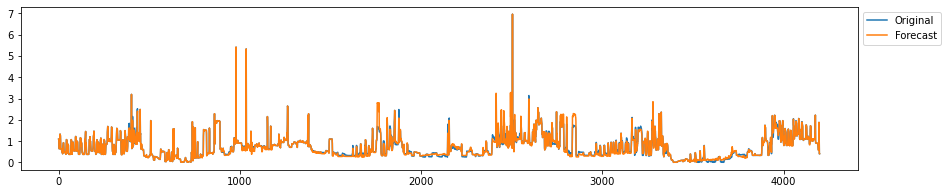

--------------------
training window 453519
Epoch 1/50
394/394 [==============================] - 1s 549us/step - loss: 0.0778
Epoch 2/50
394/394 [==============================] - 0s 591us/step - loss: 0.0351
Epoch 3/50
394/394 [==============================] - 0s 639us/step - loss: 0.0332
Epoch 4/50
394/394 [==============================] - 0s 747us/step - loss: 0.0309
Epoch 5/50
394/394 [==============================] - 0s 711us/step - loss: 0.0281
Epoch 6/50
394/394 [==============================] - 0s 748us/step - loss: 0.0270
Epoch 7/50
394/394 [==============================] - 0s 665us/step - loss: 0.0266
Epoch 8/50
394/394 [==============================] - 0s 690us/step - loss: 0.0260
Epoch 9/50
394/394 [==============================] - 0s 611us/step - loss: 0.0258
Epoch 10/50
394/394 [==============================] - 0s 617us/step - loss: 0.0255
Epoch 11/50
394/394 [==============================] - 0s 598us/step - loss: 0.0258
Epoch 12/50
394/394 [====================

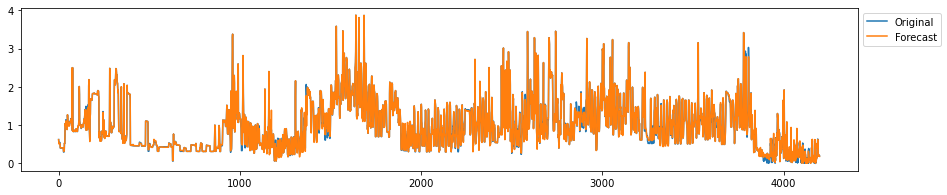

--------------------
training window 470316
Epoch 1/50
394/394 [==============================] - 1s 705us/step - loss: 0.0691
Epoch 2/50
394/394 [==============================] - 0s 607us/step - loss: 0.0323
Epoch 3/50
394/394 [==============================] - 0s 604us/step - loss: 0.0271
Epoch 4/50
394/394 [==============================] - 0s 593us/step - loss: 0.0256
Epoch 5/50
394/394 [==============================] - 0s 604us/step - loss: 0.0243
Epoch 6/50
394/394 [==============================] - 0s 594us/step - loss: 0.0237
Epoch 7/50
394/394 [==============================] - 0s 597us/step - loss: 0.0229
Epoch 8/50
394/394 [==============================] - 0s 677us/step - loss: 0.0231
Epoch 9/50
394/394 [==============================] - 0s 861us/step - loss: 0.0228
Epoch 10/50
394/394 [==============================] - 0s 631us/step - loss: 0.0226
Epoch 11/50
394/394 [==============================] - 0s 603us/step - loss: 0.0222
Epoch 12/50
394/394 [====================

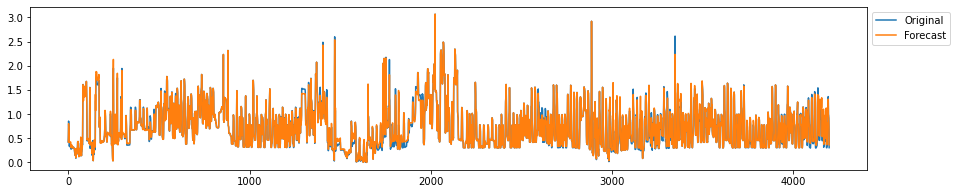

--------------------
training window 487113
Epoch 1/50
394/394 [==============================] - 1s 610us/step - loss: 0.0730
Epoch 2/50
394/394 [==============================] - 0s 626us/step - loss: 0.0318
Epoch 3/50
394/394 [==============================] - 0s 629us/step - loss: 0.0293
Epoch 4/50
394/394 [==============================] - 0s 632us/step - loss: 0.0268
Epoch 5/50
394/394 [==============================] - 0s 632us/step - loss: 0.0252
Epoch 6/50
394/394 [==============================] - 0s 625us/step - loss: 0.0247
Epoch 7/50
394/394 [==============================] - 0s 631us/step - loss: 0.0242
Epoch 8/50
394/394 [==============================] - 0s 626us/step - loss: 0.0242
Epoch 9/50
394/394 [==============================] - 0s 633us/step - loss: 0.0240
Epoch 10/50
394/394 [==============================] - 0s 637us/step - loss: 0.0231
Epoch 11/50
394/394 [==============================] - 0s 648us/step - loss: 0.0222
Epoch 12/50
394/394 [====================

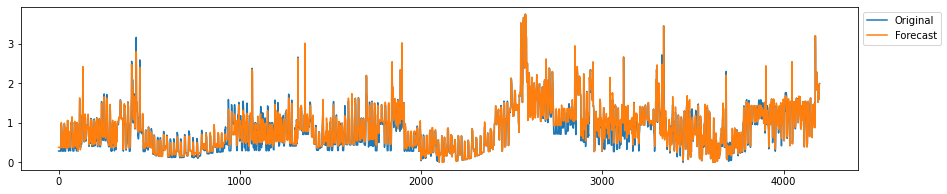

In [13]:
#Variables
# endog = data['Appliances']
# exog = data.loc[:,'lights':'Tdewpoint']
#forecasts = []
#appliances = []
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['use [kW]'].reset_index()
        appliance_train = ttrain['use [kW]'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        # Faz o treinamento 
        fts_model, encoder_model, encoded_train = train_reducted(ttrain.loc[:,'gen [kW]':'precipProbability'], appliance_train, 50)
        # Faz o teste 
        forecast, encoded_test = forecast_reducted(fts_model, encoder_model,ttest.loc[:,'gen [kW]':'precipProbability'],appliance)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        rmse = Measures.rmse(encoded_test['use [kW]'],forecast)
        mape = Measures.mape(encoded_test['use [kW]'],forecast)
        smape = Measures.smape(encoded_test['use [kW]'],forecast)
        
        #forecasts.append(forecast)
        #appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(encoded_test['use [kW]'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()

measures = pd.DataFrame(result)



In [14]:
measures

,window,rmse,mape,smape
0,0,0.069376,4.562033,2.181454
1,16797,0.101552,184.518134,5.368279
2,33594,0.088283,9.044040,4.131946
3,50391,0.123634,6.429552,3.015706
4,67188,0.104454,20.773050,5.383567
5,83985,0.060345,14.561400,4.240042
6,100782,0.073716,5.171436,2.338952
7,117579,0.070816,6.293661,3.043654
8,134376,0.083946,24.313139,4.864535
9,151173,0.088531,19.347602,5.281256


In [15]:
print("Mean: ")
print(statistics.mean(measures['rmse']))
print(statistics.mean(measures['mape']))
print(statistics.mean(measures['smape']))

Mean: 
0.10606110109252016
32.28282192998723
4.453203848261656
